In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data procewssing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
!pip install imutils

In [39]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 


In [40]:
image_dir = '/kaggle/input/brain-mri-images'


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(file_dir, filename)
            image = cv2.imread(img_path)
            if image is not None:
                image = image.reshape((1,) + image.shape)
                i = 0
                for batch in data_gen.flow(image, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpg'):
                    i += 1
                    if i >= n_generated_samples:
                        break

In [43]:
import os
import cv2

In [44]:
os.makedirs('/kaggle/working/augmented-images')
os.makedirs('/kaggle/working/augmented-images/yes')
os.makedirs('/kaggle/working/augmented-images/no')

FileExistsError: [Errno 17] File exists: '/kaggle/working/augmented-images'

In [45]:
images_yes ='/kaggle/input/brain-mri-images/yes-20240619T152050Z-001/yes'
images_no = '/kaggle/input/brain-mri-images/no-20240619T152053Z-001/no'

In [46]:
augmented_yes = '/kaggle/working/augmented-images/yes'
augmented_no = '/kaggle/working/augmented-images/no'

In [47]:
augment_data(file_dir=images_yes, n_generated_samples=6, save_to_dir=augmented_yes)

augment_data(file_dir=images_no, n_generated_samples=9, save_to_dir=augmented_no)


In [48]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [ ]:
# image_path = '/kaggle/working/augmented-images/no/aug_0_52.jpg'
# image = cv2.imread(image_path)
# cropped_image = crop_brain_contour(image, plot=True)


In [49]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [50]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 3298
X shape is: (3298, 240, 240, 3)
y shape is: (3298, 1)


In [51]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

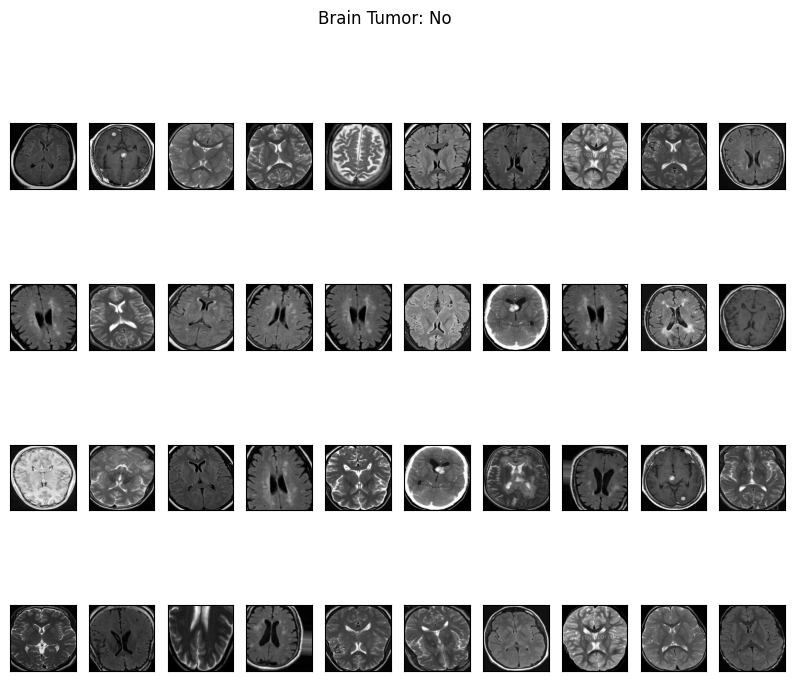

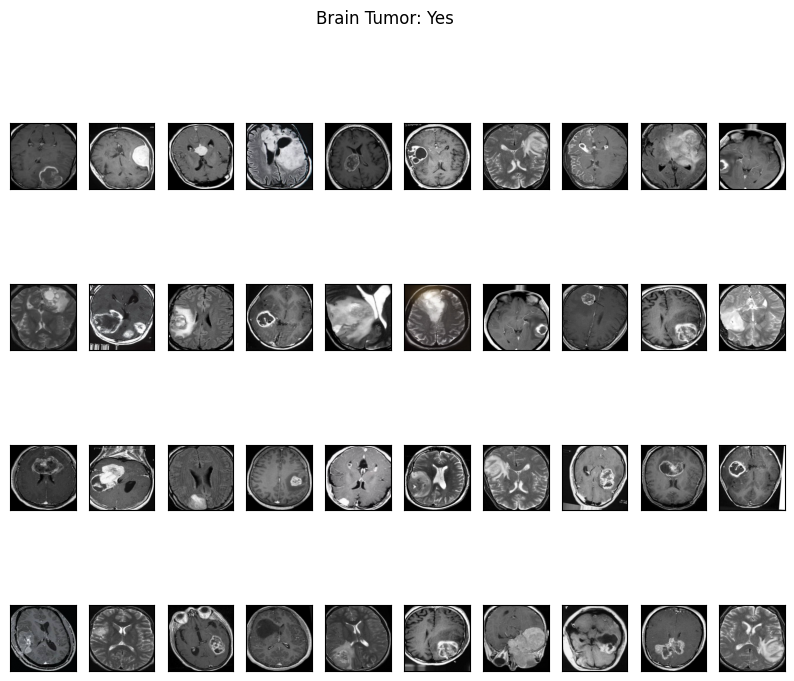

In [52]:
plot_sample_images(X, y)

In [53]:
def split_data(X, y, test_size=0.2 ,  random_state=42):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size , random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5 , random_state=random_state)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [54]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2,random_state = 42)

In [55]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2638
number of validation examples = 330
number of test examples = 330


In [56]:
from keras.layers import Dropout

In [59]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X) 
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs=X_input, outputs=X)
    
    return model


In [60]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 244, 244, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 244, 244, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 122, 122, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 122, 122, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 61, 61, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,355,521 (226.42 MB)

 Trainable params: 59,354,625 (226.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [101]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=24, validation_data=(X_val, y_val))

Epoch 1/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 0.9592 - loss: 0.1225 - val_accuracy: 0.7030 - val_loss: 4.2392
Epoch 2/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9514 - loss: 0.1279 - val_accuracy: 0.9727 - val_loss: 0.2714
Epoch 3/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9522 - loss: 0.1377 - val_accuracy: 0.9576 - val_loss: 0.1558
Epoch 4/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9596 - loss: 0.1156 - val_accuracy: 0.9424 - val_loss: 0.2545
Epoch 5/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9637 - loss: 0.1096 - val_accuracy: 0.9606 - val_loss: 0.2203
Epoch 6/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9623 - loss: 0.1095 - val_accuracy: 0.9727 - val_loss: 0.1503
Epoch 7/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9569 - loss: 0.1166 - val_accuracy: 0.9697 - val_loss: 0.1589
Epoch 8/24
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9533 - loss: 0.1338 - val_accuracy: 0.7667 

In [102]:
history = model.history.history

In [103]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

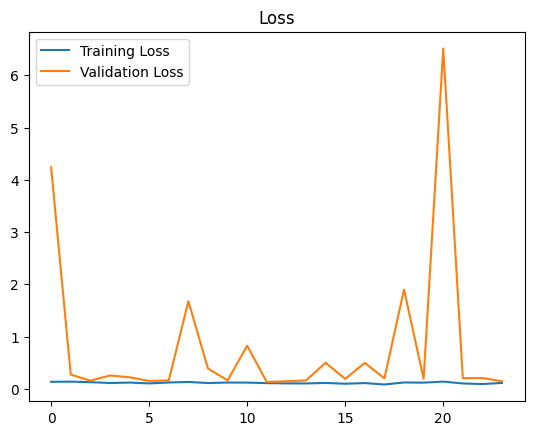

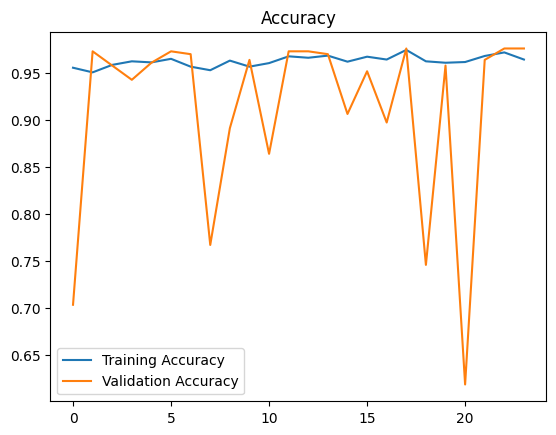

In [104]:
plot_metrics(history)

In [106]:
from sklearn.metrics import f1_score, recall_score, accuracy_score , precision_score

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

y_test_pred_binary = (y_test_pred > 0.5).astype(int)

f1 = round(f1_score(y_test, y_test_pred_binary), 2)
recall = round(recall_score(y_test, y_test_pred_binary), 2)
accuracy = round(accuracy_score(y_test, y_test_pred_binary), 2)
precision = precision_score(y_test, y_test_pred_binary)

print("F1 Score: {:.2f}%".format(f1*100))
print("Recall Score: {:.2f}%".format(recall*100))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision score: {:.2f}%".format(precision * 100))



83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
F1 Score: 97.00%
Recall Score: 98.00%
Accuracy: 97.00%
Precision score: 95.72%


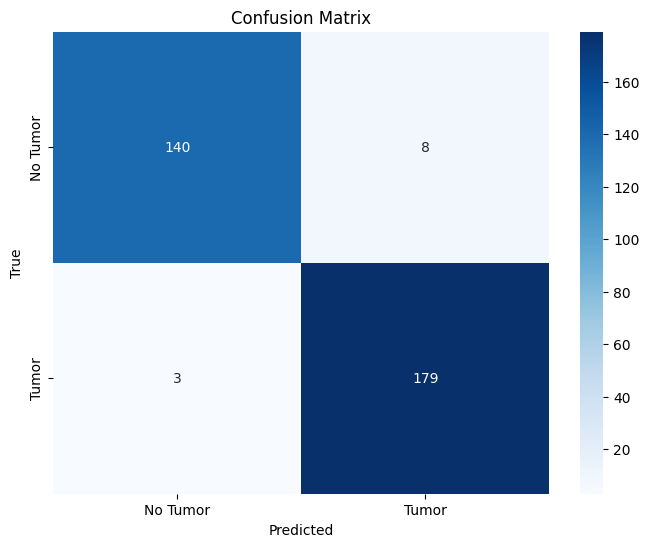

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
